https://satijalab.org/seurat/articles/pbmc3k_tutorial.html
https://rauselllab.github.io/CelliD//vignettes/vign.html#obtaining-pancreatic-cell-type-gene-signatures

In [13]:
library(CelliD)
library(tidyverse)
library(ggpubr)
library(comprehenr)
library(dplyr)
library(reshape2)
library(RColorBrewer)
library(reticulate)

In [2]:
BaronMatrix   <- readRDS(url("https://storage.googleapis.com/cellid-cbl/BaronMatrix.rds"))
BaronMetaData <- readRDS(url("https://storage.googleapis.com/cellid-cbl/BaronMetaData.rds"))

In [3]:
BaronMatrixProt <- BaronMatrix[rownames(BaronMatrix) %in% HgProteinCodingGenes,]

In [4]:
Baron <- CreateSeuratObject(counts = BaronMatrixProt, project = "Baron", min.cells = 5, meta.data = BaronMetaData)
Baron <- NormalizeData(Baron)
Baron <- ScaleData(Baron, features = rownames(Baron))

Centering and scaling data matrix



In [5]:
Baron <- RunMCA(Baron)

Computing Fuzzy Matrix



6.152 sec elapsed


Computing SVD



22.758 sec elapsed


Computing Coordinates



2.091 sec elapsed


### Obtaining reference gene set


#### pancreas cell type



In [6]:
# download all cell-type gene signatures from panglaoDB
panglao <- read_tsv("https://panglaodb.se/markers/PanglaoDB_markers_27_Mar_2020.tsv.gz")


Rows: 8286 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (8): species, official gene symbol, cell type, nicknames, product descri...
dbl (6): ubiquitousness index, canonical marker, sensitivity_human, sensitiv...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
# restricting the analysis to pancreas specific gene signatues
panglao_pancreas <- panglao %>% filter(organ == "Pancreas")


# restricting to human specific genes
panglao_pancreas <- panglao_pancreas %>%  filter(str_detect(species,"Hs"))

# converting dataframes into a list of vectors, which is the format needed as input for CellID
panglao_pancreas <- panglao_pancreas %>%  
  group_by(`cell type`) %>%  
  summarise(geneset = list(`official gene symbol`))
pancreas_gs <- setNames(panglao_pancreas$geneset, panglao_pancreas$`cell type`)

#### All cell types


In [8]:
#filter to get human specific genes
panglao_all <- panglao %>%  filter(str_detect(species,"Hs"))

# convert dataframes to a list of named vectors which is the format for CellID input
panglao_all <- panglao_all %>%  
  group_by(`cell type`) %>%  
  summarise(geneset = list(`official gene symbol`))
all_gs <- setNames(panglao_all$geneset, panglao_all$`cell type`)

#remove very short signatures
all_gs <- all_gs[sapply(all_gs, length) >= 10]

Check how to feed simba marker into RunCellHGT

From https://github.com/RausellLab/CelliD/blob/master/R/hyper.R


In [9]:
RunCellHGT_custom <-
    function(X, pathways, reduction = "mca", n.features = 200, features = NULL, dims = seq(50), minSize = 10, log.trans = TRUE, p.adjust = TRUE, cg_distance = NULL) {
        #DT <- GetCellGeneDistance(X, dims = dims, features = features, reduction = reduction)
        require(Matrix)
        DT <- cg_distance
        message("ranking genes")
        features <- rownames(DT)
        cells <- colnames(DT)

        # Target ------------------------------------------------------------------
        i <- pbapply::pbapply(DT, 2, order)[seq(n.features), ]
        j <- rep(seq(ncol(DT)), each = n.features)
        TargetMatrix <- sparseMatrix(i, j, x = 1, dims = c(length(features), length(cells)), dimnames = list(features, cells))

        # Geneset -----------------------------------------------------------------
        nPathInit <- length(pathways)
        pathways <- lapply(pathways, function(x) x[x %in% features])
        pathways <- pathways[vapply(pathways, function(x) length(x) >= minSize, FUN.VALUE = logical(1))]
        nPathEnd <- length(pathways)
        nFiltPath <- nPathInit - nPathEnd
        if(nPathEnd == 0){
            stop(cat("All pathways have less than {minSize} features in common with the data"))
        }
        message(cat("{nPathEnd} pathways kept for hypergeometric test out of {nPathInit}, {nFiltPath} filtered as less than {minSize} features was present in the data"))
        message("\ncalculating features overlap\n")
        PathwayMat <- pbapply::pbsapply(pathways, function(x) which(features %in% x), simplify = FALSE)
        PathwayLen <- unlist(lapply(PathwayMat, length))
        j <- rep(seq(length(PathwayMat)), times = PathwayLen)
        PathwayMatrix <- sparseMatrix(unlist(PathwayMat), j, x = 1, dims = c(length(features), length(PathwayMat)), dimnames = list(features, names(PathwayMat)))

        # Hypergeo ----------------------------------------------------------------
        q <- as.data.frame((t(TargetMatrix) %*% PathwayMatrix) - 1)
        m <- vapply(pathways, function(x) sum(x %in% features), FUN.VALUE = numeric(1))
        n <- vapply(m, function(x) length(features) - x, FUN.VALUE = numeric(1))
        k <- n.features
        message("performing hypergeometric test\n")
        A <- pbapply::pbmapply(
            FUN = function(q, m, n, k) {
                listhyper <- phyper(seq(-1, max(q)), m, n, k, lower.tail = FALSE)[q + 2]
                return(listhyper)
            },
            q = q,
            m = m,
            n = n,
            k = k
        )
        rownames(A) <- rownames(q)
        A <- t(A)
        if (p.adjust) {
            A <- apply(A, 2, function(x) p.adjust(x, "BH"))
        }
        if (log.trans) {
            A <- as.sparse(as.matrix(-log10(A)))
        }
        return(A)
    }

### Load SIMBA result

In [10]:
simba_cell_annot <- read.csv("baron_cells.txt")
simba_gene_annot <- read.csv("baron_genes.txt")

In [14]:
np <- import("numpy")
load_np_matrix <- function(npz_path, row_annot=rownames(simba_cell_annot), col_annot=simba_gene_annot$X){
    npz <- np$load(npz_path)
    matrix <- npz[['arr_0']]
    rownames(matrix) <- row_annot
    colnames(matrix) <- col_annot
    gc_matrix = t(matrix)
    gc_matrix_aligned <- gc_matrix[match(rownames(Baron_common), rownames(gc_matrix)), match(colnames(Baron_common), colnames(gc_matrix))]
    return(gc_matrix_aligned)
}

In [17]:
Baron_common <- subset(Baron, features=rownames(Baron)[!is.na(match(rownames(Baron), simba_gene_annot))])

In [21]:
Baron_common <- RunMCA(Baron_common)

Computing Fuzzy Matrix



6.13 sec elapsed


Computing SVD



23.644 sec elapsed


Computing Coordinates



1.902 sec elapsed


In [18]:
simba_raw_score <- load_np_matrix('baron_cmp_norm.npz')
simba_norm_score <- load_np_matrix('baron_cmp_norm.npz')
simba_softmax_score <- load_np_matrix('baron_cmp_softmax.npz')

As simba provides similarity instead of dissimilarity or distance between cells and genes, we provide negative similarity score as the distance.


In [19]:
get_signif_prediction_perf <- function(n_features_list, simba_matrix, calculate_cellid = FALSE, pathways=pancreas_gs, sig_cutoff=TRUE){
    cell_id_pred <- list()
    simba_pred <- list()
    cell_id_perfs <- c()
    simba_perfs <- c()
    cell_id_perfs_ct <- list()
    simba_perfs_ct <- list()
    for (n.features in n_features_list){
        message(paste0("Calculating for ", n.features, " features"))
        if(calculate_cellid){
            HGT_pancreas_gs <- RunCellHGT(Baron_common, pathways = pathways, dims = 1:50, n.features = n.features)

            # For each cell, assess the signature with the lowest corrected p-value (max -log10 corrected p-value)
            pancreas_gs_prediction <- rownames(HGT_pancreas_gs)[apply(HGT_pancreas_gs, 2, which.max)]

            # For each cell, evaluate if the lowest p-value is significant
            if(sig_cutoff){
                pancreas_gs_prediction_signif <- ifelse(apply(HGT_pancreas_gs, 2, max)>2, yes = pancreas_gs_prediction, "unassigned")} else{
                pancreas_gs_prediction_signif <- pancreas_gs_prediction
            }

            # Save cell type predictions as metadata within the Seurat object
            Baron_common$pancreas_gs_prediction <- pancreas_gs_prediction_signif
            cell_id_pred <- c(cell_id_pred, list(pancreas_gs_prediction_signif))
            cellid_perf <- sum(Baron_common[['cell.type']] == Baron_common$pancreas_gs_prediction)/nrow(Baron_common[['cell.type']])
            cell_id_perfs <- c(cell_id_perfs, cellid_perf)
            message(cellid_perf)

            df = Baron_common[['cell.type']]
            df['pred'] = Baron_common[['cell.type']] == Baron_common$pancreas_gs_prediction
            cellid_perf_ct <- df %>% group_by(cell.type) %>% summarise(mean(pred),sum(pred))
            cell_id_perfs_ct <- c(cell_id_perfs_ct, list(cellid_perf_ct))
        }
        HGT_simba <- RunCellHGT_custom(Baron_common, pathways = pathways, dims = 1:50, n.features = n.features, cg_distance=-simba_matrix)
        simba_gs_prediction <- rownames(HGT_simba)[apply(HGT_simba, 2, which.max)]

        if(sig_cutoff){
        simba_gs_prediction_signif <- ifelse(apply(HGT_pancreas_gs, 2, max)>2, yes = simba_gs_prediction, "unassigned")
            }else{
            simba_gs_prediction_signif <- simba_gs_prediction
        }

        # Save cell type predictions as metadata within the Seurat object
        Baron_common$simba_gs_prediction <- simba_gs_prediction_signif
        simba_pred <- c(simba_pred, list(simba_gs_prediction_signif))
        simba_perf <- sum(Baron_common[['cell.type']] == Baron_common$simba_gs_prediction)/nrow(Baron_common[['cell.type']])
        simba_perfs <- c(simba_perfs, simba_perf)
        message(simba_perf)

        df = Baron_common[['cell.type']]
        df['pred'] = Baron_common[['cell.type']] == Baron_common$simba_gs_prediction
        simba_perf_ct <- df %>% group_by(cell.type) %>% summarise(mean(pred),sum(pred))
        simba_perfs_ct <- c(simba_perfs_ct, list(simba_perf_ct))
    }
    return(list(cell_id_pred, simba_pred, cell_id_perfs, simba_perfs, cell_id_perfs_ct, simba_perfs_ct))
}

In [22]:
n_features=c(10, 50, 100, 200, 500, 1000)
res_list <- get_signif_prediction_perf(n_features, simba_softmax_score, TRUE, all_gs, FALSE)
cellid_ct_perf <- res_list[[5]]
simba_ct_perf <- res_list[[6]]

Calculating for 10 features


calculating distance


ranking genes

141 pathways kept for hypergeometric test out of 151, 10 filtered as less than 10 features was present in the data


calculating features overlap


performing hypergeometric test


0.27039327809546

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


The following object is masked from ‘package:S4Vectors’:

    expand


ranking genes



{nPathEnd} pathways kept for hypergeometric test out of {nPathInit}, {nFiltPath} filtered as less than {minSize} features was present in the data




calculating features overlap


performing hypergeometric test


0.598903022523048

Calculating for 50 features


calculating distance


ranking genes

141 pathways kept for hypergeometric test out of 151, 10 filtered as less than 10 features was present in the data


calculating features overlap


performing hypergeometric test


0.554090325592251

ranking genes



{nPathEnd} pathways kept for hypergeometric test out of {nPathInit}, {nFiltPath} filtered as less than {minSize} features was present in the data




calculating features overlap


performing hypergeometric test


0.773369121251021

Calculating for 100 features


calculating distance


ranking genes

141 pathways kept for hypergeometric test out of 151, 10 filtered as less than 10 features was present in the data


calculating features overlap


performing hypergeometric test


0.649083907107014

ranking genes



{nPathEnd} pathways kept for hypergeometric test out of {nPathInit}, {nFiltPath} filtered as less than {minSize} features was present in the data




calculating features overlap


performing hypergeometric test


0.802427354417085

Calculating for 200 features


calculating distance


ranking genes

141 pathways kept for hypergeometric test out of 151, 10 filtered as less than 10 features was present in the data


calculating features overlap


performing hypergeometric test


0.718753646866612

ranking genes



{nPathEnd} pathways kept for hypergeometric test out of {nPathInit}, {nFiltPath} filtered as less than {minSize} features was present in the data




calculating features overlap


performing hypergeometric test


0.818415217644999

Calculating for 500 features


calculating distance


ranking genes

141 pathways kept for hypergeometric test out of 151, 10 filtered as less than 10 features was present in the data


calculating features overlap


performing hypergeometric test


0.760298751312872

ranking genes



{nPathEnd} pathways kept for hypergeometric test out of {nPathInit}, {nFiltPath} filtered as less than {minSize} features was present in the data




calculating features overlap


performing hypergeometric test


0.841405064768351

Calculating for 1000 features


calculating distance


ranking genes

141 pathways kept for hypergeometric test out of 151, 10 filtered as less than 10 features was present in the data


calculating features overlap


performing hypergeometric test


0.772085424203524

ranking genes



{nPathEnd} pathways kept for hypergeometric test out of {nPathInit}, {nFiltPath} filtered as less than {minSize} features was present in the data




calculating features overlap


performing hypergeometric test


0.847590150542654



In [39]:
cell_counts = data.frame(table(Baron_common[['cell.type']]))[,2]
get_single_dfs <- function(df_list, cell_counts=cell_counts){
ct_df = bind_cols(to_list(for (i in 1:length(df_list)){if(i==1){
    df_list[[i]][c(1,2)]}else{
    df_list[[i]][2]}}), )
colnames(ct_df) <- c("cell_type", n_features)
count_df = cbind(ct_df[1],sweep(ct_df[,2:ncol(ct_df)], 1, STATS=cell_counts, FUN="*"))
    return(list(ct_df, count_df))
    
    }

In [40]:
res <- get_single_dfs(simba_ct_perf, cell_counts)
simba_ct_frac_list <- res[[1]]
simba_ct_list <- res[[2]]
simba_ct_melt = melt(simba_ct_list)
simba_ct_melt$method <- 'SIMBA'

res <- get_single_dfs(cellid_ct_perf, cell_counts)
cellid_ct_frac_list <- res[[1]]
cellid_ct_list <- res[[2]]
cellid_ct_melt = melt(cellid_ct_list)
cellid_ct_melt$method <- "CellID"
plot_df = rbind(cellid_ct_melt, simba_ct_melt)

New names:
• `mean(pred)` -> `mean(pred)...2`
• `mean(pred)` -> `mean(pred)...3`
• `mean(pred)` -> `mean(pred)...4`
• `mean(pred)` -> `mean(pred)...5`
• `mean(pred)` -> `mean(pred)...6`
• `mean(pred)` -> `mean(pred)...7`
Using cell_type as id variables

New names:
• `mean(pred)` -> `mean(pred)...2`
• `mean(pred)` -> `mean(pred)...3`
• `mean(pred)` -> `mean(pred)...4`
• `mean(pred)` -> `mean(pred)...5`
• `mean(pred)` -> `mean(pred)...6`
• `mean(pred)` -> `mean(pred)...7`
Using cell_type as id variables



In [41]:
cellid_ct_list


cell_type,10,50,100,200,500,1000
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Acinar cells,700,929,934,940,943,946
Alpha cells,198,966,1299,1524,1634,1702
Beta cells,396,1364,1722,2002,2196,2247
Delta cells,448,563,570,571,573,574
Ductal cells,81,324,417,524,575,558
Endothelial cells,180,236,240,246,246,245
Epsilon cells,13,8,8,4,2,1
Gamma (PP) cells,245,252,255,255,255,253
Macrophages,22,43,49,53,52,52


In [29]:
# Theme from https://rpubs.com/Koundy/71792
theme_Publication <- function(base_size=14, base_family="helvetica") {
      library(grid)
      library(ggthemes)
      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_line(colour="#f0f0f0"),
               panel.grid.minor = element_blank(),
               legend.key = element_rect(colour = NA),
               legend.position = "bottom",
               legend.direction = "horizontal",
               legend.key.size= unit(0.2, "cm"),
               legend.margin = unit(0, "cm"),
               legend.title = element_text(face="italic"),
               plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          ))
      
}
getPalette = colorRampPalette(brewer.pal(9, "Paired"))

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


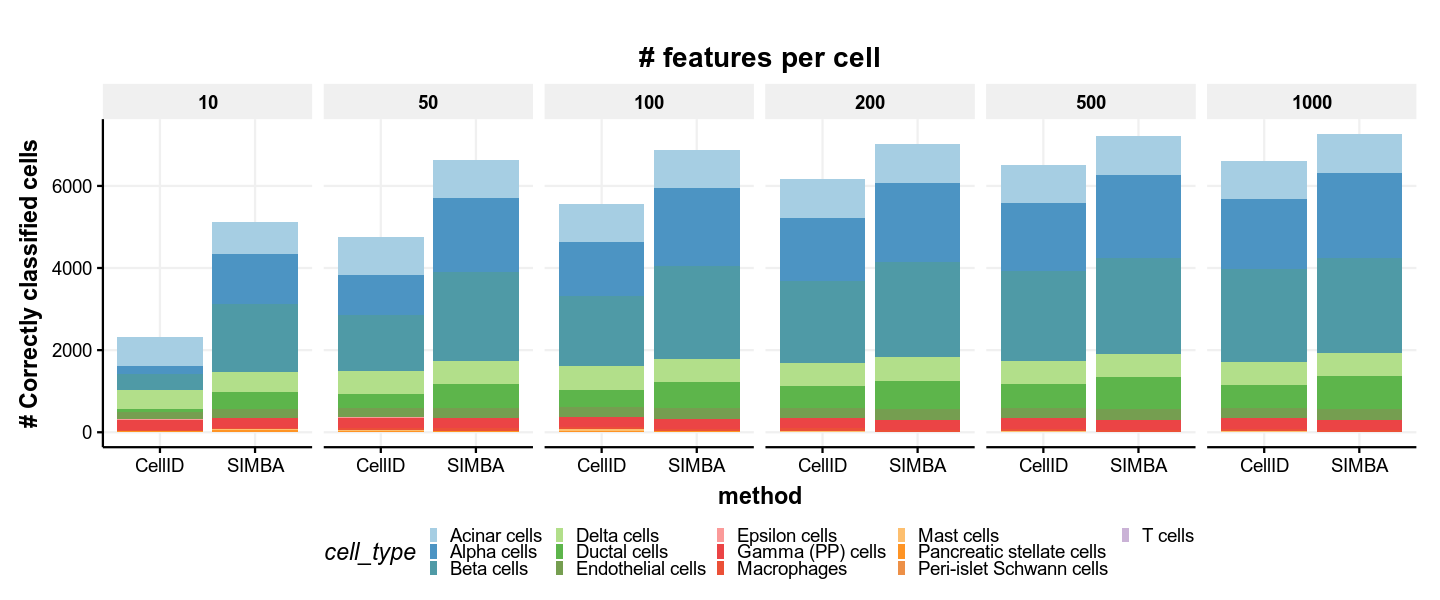

In [42]:
options(repr.plot.width=12, repr.plot.height=5)
ggplot(plot_df, aes(fill=cell_type, y=value, x=method,)) + facet_wrap(~variable,nrow=1)+
geom_bar(position="stack", stat="identity") + theme_Publication() + scale_fill_manual(values = getPalette(13)) + ylab("# Correctly classified cells") + ggtitle("# features per cell")

In [48]:
plot_df$prop <- plot_df$value/ncol(Baron_common)*100

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


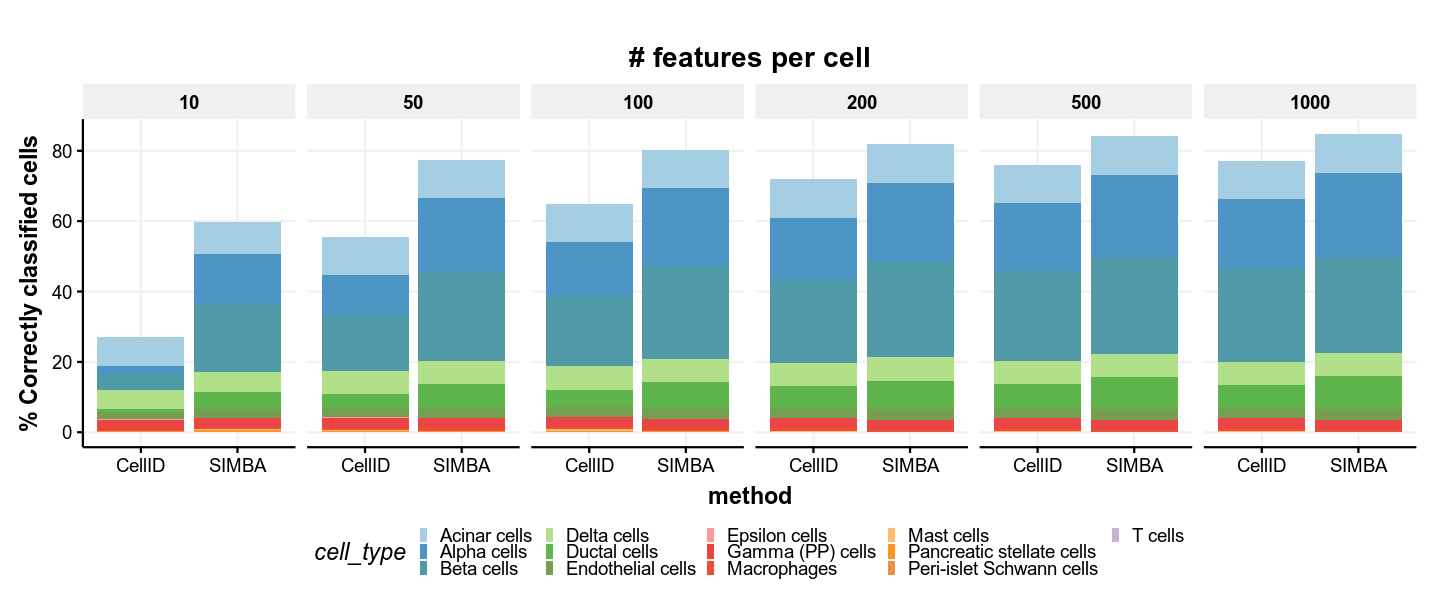

In [49]:
options(repr.plot.width=12, repr.plot.height=5)
ggplot(plot_df, aes(fill=cell_type, y=prop, x=method,)) + facet_wrap(~variable,nrow=1)+
geom_bar(position="stack", stat="identity") + theme_Publication() + scale_fill_manual(values = getPalette(13)) + ylab("% Correctly classified cells") + ggtitle("# features per cell")